# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 練習特徵重要性的寫作與觀察

# [作業重點]
- 仿造範例, 完成特徵重要性的計算, 並觀察對預測結果的影響 (In[3]~[5], Out[3]~[5]) 
- 仿造範例, 將兩個特徵重要性最高的特徵重組出新特徵, 並觀察對預測結果的影響 (In[8], Out[8]) 

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

data_path = '../Part02/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c]))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = RandomForestClassifier(random_state=1)
estimator.fit(df.values, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

Sex         0.251130
Ticket      0.156110
Fare        0.133259
Name        0.131550
Age         0.119793
Cabin       0.066426
Pclass      0.054572
SibSp       0.034515
Parch       0.033646
Embarked    0.019000
dtype: float64

In [4]:
pd.DataFrame(estimator.feature_importances_
             ,index=df.columns
             ,columns=['feature_importance']).sort_values(by='feature_importance',ascending=False)

,feature_importance
Sex,0.251130
Ticket,0.156110
Fare,0.133259
Name,0.131550
Age,0.119793
Cabin,0.066426
Pclass,0.054572
SibSp,0.034515
Parch,0.033646
Embarked,0.019000


## 先用隨機森林對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?

In [5]:
feats.index[:int(len(feats)/2)]

Index(['Sex', 'Ticket', 'Fare', 'Name', 'Age'], dtype='object')

In [6]:
# 高重要性特徵 + 隨機森林
high_feature = feats.index[:int(len(feats)/2)]
train_high = pd.DataFrame(MMEncoder.fit_transform(df[high_feature]))
cross_val_score(estimator, train_high, train_Y, cv=5).mean()

0.8047053908681756

In [7]:
# 原始特徵 + 隨機森林
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.818270564407879

    #將特徵重要性較低的一半特徵刪除後，預估正確率小幅下降

# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?

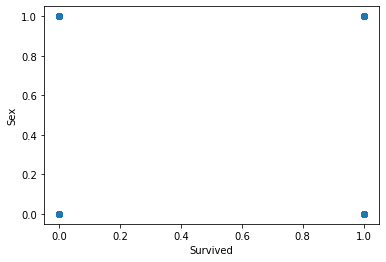

In [12]:
# 觀察重要特徵與目標的分布
# 第一名              
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x=train_Y, y=df[feats.index[0]], fit_reg=False)
plt.show()

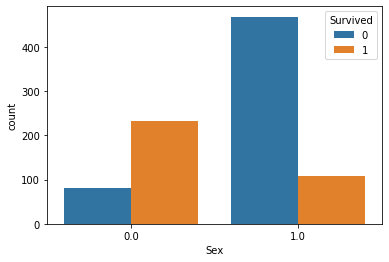

In [13]:
sns.countplot(df[feats.index[0]], hue=train_Y)

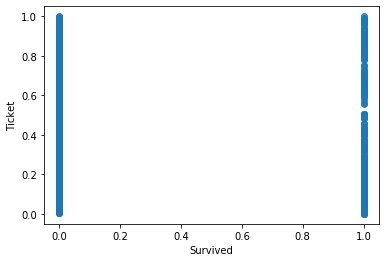

In [14]:
# 第二名       
sns.regplot(x=train_Y, y=df[feats.index[1]], fit_reg=False)
plt.show()

In [16]:
# 製作新特徵看效果
df['SexAddTicket'] = (df['Sex']+df['Ticket'])/2
#df['SexMultiTicket'] = df['Sex']*df['Ticket']
df['SexDivideTicket'] = df['Sex']/(df['Ticket']+1)*2
train_X = MMEncoder.fit_transform(df)
print(cross_val_score(estimator, train_X, train_Y, cv=5).mean())
print(cross_val_score(estimator, df, train_Y, cv=5).mean())

0.8249809648742972
0.8249809648742972


In [17]:
train_high.head()

,0,1,2,3,4
0,1.0,0.769118,0.014151,0.121348,0.283951
1,0.0,0.876471,0.139136,0.213483,0.481481
2,0.0,0.983824,0.015469,0.396629,0.333333
3,0.0,0.072059,0.103644,0.305618,0.444444
4,1.0,0.694118,0.015713,0.016854,0.444444


In [22]:
train_high['SexAddTicket'] = (train_high[0]+train_high[1])/2
#train_high['SexMultiTicket'] = train_high[0]*train_high[1]
train_high['SexDivideTicket'] = train_high[0]/(train_high[1]+1)*2
train_X = MMEncoder.fit_transform(train_high)
print(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

0.8136501444967298


In [23]:
train_high.head()

,0,1,2,3,4,SexAddTicket,SexDivideTicket
0,1.0,0.769118,0.014151,0.121348,0.283951,0.884559,1.130507
1,0.0,0.876471,0.139136,0.213483,0.481481,0.438235,0.000000
2,0.0,0.983824,0.015469,0.396629,0.333333,0.491912,0.000000
3,0.0,0.072059,0.103644,0.305618,0.444444,0.036029,0.000000
4,1.0,0.694118,0.015713,0.016854,0.444444,0.847059,1.180556


    #將特徵重要性最高的兩個特徵做特徵組合，預測力小幅上升